In [310]:
import torch 
import torch.nn as nn
import os 
import sys
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, AlphaFoldDataset, GeneOntologyDataset, ProteinFamilyDataset
from src.utils import data_utils as dtu
from torch.utils.data import DataLoader, Dataset, Subset
from src.models.basicVae import LitBasicVae
# from src.models.basicVae_pyt import BasicVae
import numpy as np
from src.dataset_classes.sequenceDataset import *
from sklearn.model_selection import KFold
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset = ProteinFamilyDataset(root='../data').to_point().torch()

In [311]:
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

Random Subset: [6, 0, 23, 21, 37, 84, 64, 44, 82, 24]
Remaining Subset: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [312]:
idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

In [313]:
s = 400
train_subset = SequenceDataset(Subset(dataset, train_idx), s)
val_subset = SequenceDataset(Subset(dataset, val_idx), s)

100%|██████████| 3110/3110 [00:01<00:00, 2639.00it/s]


In [314]:
def ELBO(x, x_hat, x_mu, x_logvar):
    rec_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + x_logvar - x_mu.pow(2) - x_logvar.exp())
    return (rec_loss + KL_loss) / x.size(0) 


In [315]:
len(train_subset)

22455

In [376]:
latent_dim = 64
epochs = 100
lr = 0.001
batch_size = 128
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset,batch_size=batch_size, shuffle=False)
x_dim = train_subset[0].shape[0]
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [377]:
next(iter(train_dataloader))[0].shape

torch.Size([400, 21])

In [381]:
model = LitBasicVae(latent_dim=latent_dim, seq_len= s, hidden_dim= 256, amino_acids = 21, optimizer=torch.optim.Adam, optimizer_param={'lr':0.001}, beta = 1, dropout = 0.0, reconstruction_loss_weight = 1)
model

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (fc1_enc): Linear(in_features=8400, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_enc_mean): Linear(in_features=256, out_features=64, bias=True)
  (fc3_enc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (fc1_dec): Linear(in_features=64, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_dec): Linear(in_features=256, out_features=8400, bias=True)
  (bn3): BatchNorm1d(8400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [382]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))
# model = LitBasicVae(latent_dim, x_dim, optimizer, optimizer_param,)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [383]:
trainer.fit(model, train_dataloader, val_dataloader)


   | Name           | Type        | Params | Mode 
--------------------------------------------------------
0  | tanh           | Tanh        | 0      | train
1  | soft           | Softmax     | 0      | train
2  | dropout_layer  | Dropout     | 0      | train
3  | fc1_enc        | Linear      | 2.2 M  | train
4  | bn1            | BatchNorm1d | 512    | train
5  | fc3_enc_mean   | Linear      | 16.4 K | train
6  | fc3_enc_logvar | Linear      | 16.4 K | train
7  | fc1_dec        | Linear      | 16.6 K | train
8  | bn2            | BatchNorm1d | 512    | train
9  | fc3_dec        | Linear      | 2.2 M  | train
10 | bn3            | BatchNorm1d | 16.8 K | train
--------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.507    Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
for batch in train_dataloader:
    model

# Model Visualisation

In [171]:
dataset = ProteinFamilyDataset(root = '../data').to_point().torch()

In [167]:
# Load the trained model from checkpoint
checkpoint_path = "logs/lightning_logs/version_18/checkpoints/epoch=99-step=10200.ckpt"
model = LitBasicVae.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()


LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=128, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=128, bias=True)
  (fc1_dec): Linear(in_features=128, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [215]:
input = next(iter(train_dataloader))
model.to('cpu')

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc): Linear(in_features=5250, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=128, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=128, bias=True)
  (fc1_dec): Linear(in_features=128, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=5250, bias=True)
)

In [384]:
reparam_z, x_mu, x_logvar, x_rec, logit = model(next(iter(train_dataloader)))

In [385]:
input[0].argmax(dim=-1).shape

torch.Size([250])

In [386]:
x_rec[0].argmax(dim=-1) == input[0].argmax(dim=-1)

RuntimeError: The size of tensor a (400) must match the size of tensor b (250) at non-singleton dimension 0

In [118]:
x_true_indices = input.argmax(dim=-1)
torch.nn.functional.cross_entropy(logit.permute(0,2,1),x_true_indices, reduction='sum')

tensor(921769.5625, grad_fn=<NllLoss2DBackward0>)

In [387]:
seq_dataset = SequenceDataset(dataset, s, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size= 256, shuffle = False)






























































































100%|██████████| 31109/31109 [00:09<00:00, 3275.90it/s]


In [388]:
seq_dataset.org_protein_data[0][1]['protein']['Pfam'][0]

'PF00102'

In [401]:
lengths = [k[0].shape[0] for k in seq_dataset.org_protein_data]
families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]

In [402]:
families

['PF00102',
 'PF00034',
 'PF00062',
 'PF00180',
 'PF00782',
 'PF14575',
 'PF00550',
 'PF01709',
 'PF00498',
 'PF12799',
 'PF00076',
 'PF00158',
 'PF00215',
 'PF00293',
 'PF13419',
 'PF00419',
 'PF16916',
 'PF00579',
 'PF00936',
 'PF00377',
 'PF01620',
 'PF10421',
 'PF01082',
 'PF17384',
 'PF07654',
 'PF13649',
 'PF01738',
 'PF00622',
 'PF13354',
 'PF00856',
 'PF01353',
 'PF08715',
 'PF00537',
 'PF01288',
 'PF05173',
 'PF03414',
 'PF00067',
 'PF00565',
 'PF00069',
 'PF01083',
 'PF00084',
 'PF01522',
 'PF00059',
 'PF14028',
 'PF00072',
 'PF00571',
 'PF17913',
 'PF00959',
 'PF00188',
 'PF01353',
 'PF01327',
 'PF02567',
 'PF00672',
 'PF05908',
 'PF17655',
 'PF00413',
 'PF02779',
 'PF17936',
 'PF01485',
 'PF00907',
 'PF01282',
 'PF08460',
 'PF07714',
 'PF00258',
 'PF00004',
 'PF03283',
 'PF00104',
 'PF00535',
 'PF17864',
 'PF07726',
 'PF16868',
 'PF13243',
 'PF01738',
 'PF00233',
 'PF00085',
 'PF03344',
 'PF16366',
 'PF00337',
 'PF09414',
 'PF03414',
 'PF00196',
 'PF01395',
 'PF01417',
 'PF

In [391]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (fc1_enc): Linear(in_features=8400, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_enc_mean): Linear(in_features=256, out_features=64, bias=True)
  (fc3_enc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (fc1_dec): Linear(in_features=64, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_dec): Linear(in_features=256, out_features=8400, bias=True)
  (bn3): BatchNorm1d(8400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [392]:
labels = []
latent_coord = []
model.eval()
total_samples = []
for batch_i, batch in enumerate(seq_dataloader):
    # print(batch.shape)
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch)
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [393]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

In [394]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 

In [395]:
latent_coord.shape

(24936, 64)

In [396]:
projected_data.shape

torch.Size([24936, 2])

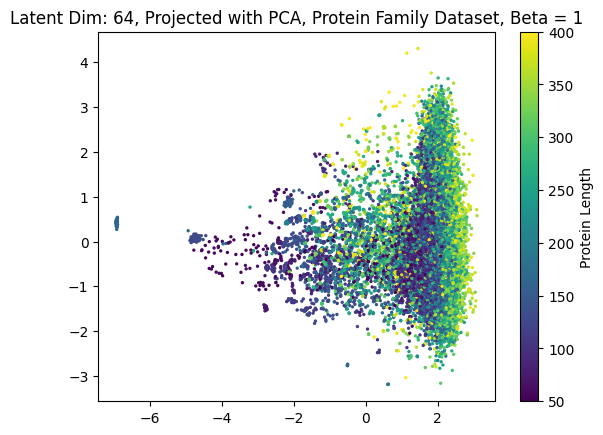

In [397]:
import matplotlib.pyplot as plt
plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 2, c=lengths, cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")

In [399]:
projected_data.shape

torch.Size([24936, 2])

The most common protein family is: PF00069


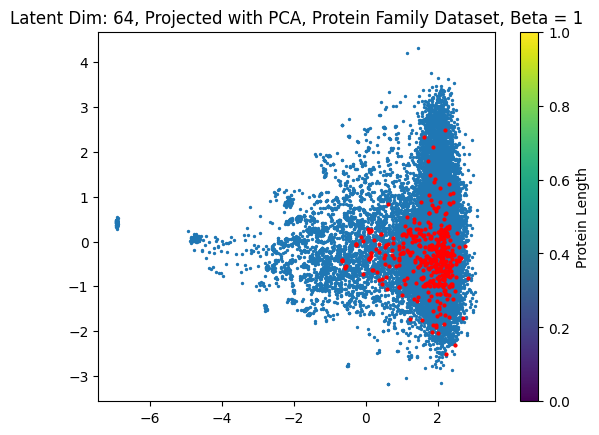

In [403]:
from collections import Counter
# Example list of strings
protein_families = families
# Count occurrences of each element
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")

family_array = np.array(families)
most_common_indices = np.where((family_array == most_common_string) == 1)
most_common_points = projected_data[most_common_indices, :]

plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 2)
plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 4, c='r')

plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")